**129L Section 4** <br>
*1/28 and 1/30*

In [54]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.sparse import dok_matrix
from scipy.sparse.linalg import eigsh
from scipy.sparse import csr_matrix
from scipy.linalg import lu_factor, lu_solve

**Task 1: Master Theorem, Time Complexity, and Strassen's Algorithm**

Recursive Form: $T(n)=aT(\frac{n}{b})+f(n)$

Question 1: Naive divide and conquer approach

Recursion formula for this question: $T(n) = 8T(\frac{n}{2})+O(n^2)$

In [2]:
# use top-down approach
def naive_matrix_mult(A, B):
    """
    Naive divide-and-conquer matrix multiplication of two square matrices A and B.
    """
    n = A.shape[0]
    
    # Base case: when the matrix is 1x1
    if n == 1:
        return A * B

    # Divide the matrices into submatrices
    mid = n // 2
    A11, A12, A21, A22 = A[:mid, :mid], A[:mid, mid:], A[mid:, :mid], A[mid:, mid:]
    B11, B12, B21, B22 = B[:mid, :mid], B[:mid, mid:], B[mid:, :mid], B[mid:, mid:]

    # Recursive multiplication
    C11 = naive_matrix_mult(A11, B11) + naive_matrix_mult(A12, B21)
    C12 = naive_matrix_mult(A11, B12) + naive_matrix_mult(A12, B22)
    C21 = naive_matrix_mult(A21, B11) + naive_matrix_mult(A22, B21)
    C22 = naive_matrix_mult(A21, B12) + naive_matrix_mult(A22, B22)

    # Combine the submatrices into the resulting matrix
    C = np.zeros((n, n))
    C[:mid, :mid] = C11
    C[:mid, mid:] = C12
    C[mid:, :mid] = C21
    C[mid:, mid:] = C22

    return C

In [3]:
# Example usage
if __name__ == "__main__":
    # Define two example matrices of size 4x4
    A = np.array([[1, 2, 3, 4],
                  [5, 6, 7, 8],
                  [9, 10, 11, 12],
                  [13, 14, 15, 16]])
    
    B = np.array([[17, 18, 19, 20],
                  [21, 22, 23, 24],
                  [25, 26, 27, 28],
                  [29, 30, 31, 32]])
    
    # Multiply using the naive divide-and-conquer algorithm
    C = naive_matrix_mult(A, B)
    print("Resulting matrix C:")
    print(C)

Resulting matrix C:
[[ 250.  260.  270.  280.]
 [ 618.  644.  670.  696.]
 [ 986. 1028. 1070. 1112.]
 [1354. 1412. 1470. 1528.]]


Critical exponent $p=\log_b{(a)} = 3$, <br>
where a=8, b=2, and d=2. <br>
Since $p>d$, the time complexity is dominated by p, and the time complexity is $O(n^3)$.

3.6002414855650602e-06 2.898730416608778 128


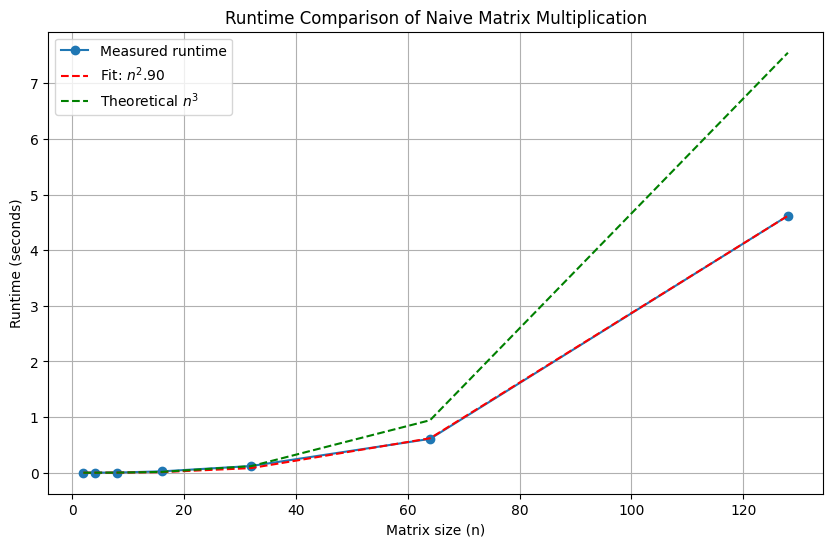

Estimated critical exponent from runtime data: p = 2.90


In [22]:
# Function to fit the runtime data
def power_law(n, c, p):
    return c * n**p

# Measure runtimes
sizes = [2**i for i in range(1, 8)]  # Matrix sizes 2^i x 2^i
runtimes = []

for n in sizes:
    A = np.random.rand(n, n)
    B = np.random.rand(n, n)
    start_time = time.time()
    naive_matrix_mult(A, B)
    end_time = time.time()
    runtimes.append(end_time - start_time)

# Fit the runtime data to a power law to estimate p
popt, _ = curve_fit(power_law, sizes, runtimes)
c_est, p_est = popt

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(sizes, runtimes, 'o-', label="Measured runtime")
print(c_est, p_est, n)
plt.plot(sizes, [power_law(n, c_est, p_est) for n in sizes], 'r--', label=f"Fit: $n^{p_est:.2f}$")
plt.plot(sizes, [power_law(n, c_est, 3) for n in sizes], 'g--', label="Theoretical $n^3$")
plt.xlabel("Matrix size (n)")
plt.ylabel("Runtime (seconds)")
plt.title("Runtime Comparison of Naive Matrix Multiplication")
plt.legend()
plt.grid(True)
plt.show()

print(f"Estimated critical exponent from runtime data: p = {p_est:.2f}")

The theoretical p=3 is close to the best fit p=2.9. As n increases, it gets even closer.

Question 2: Strassen's Algorithm

In [23]:
def strassen_matrix_mult(A, B):
    """
    Perform matrix multiplication using Strassen's Algorithm.
    A and B must be square matrices of size n x n where n is a power of 2.
    """
    n = A.shape[0]
    if n == 1:
        # Base case: 1x1 matrix multiplication
        return A * B
    
    # Split matrices into quadrants
    mid = n // 2
    A11, A12, A21, A22 = A[:mid, :mid], A[:mid, mid:], A[mid:, :mid], A[mid:, mid:]
    B11, B12, B21, B22 = B[:mid, :mid], B[:mid, mid:], B[mid:, :mid], B[mid:, mid:]

    # Compute the 7 products (M1 to M7)
    M1 = strassen_matrix_mult(A11 + A22, B11 + B22)
    M2 = strassen_matrix_mult(A21 + A22, B11)
    M3 = strassen_matrix_mult(A11, B12 - B22)
    M4 = strassen_matrix_mult(A22, B21 - B11)
    M5 = strassen_matrix_mult(A11 + A12, B22)
    M6 = strassen_matrix_mult(A21 - A11, B11 + B12)
    M7 = strassen_matrix_mult(A12 - A22, B21 + B22)

    # Compute the resulting submatrices of C
    C11 = M1 + M4 - M5 + M7
    C12 = M3 + M5
    C21 = M2 + M4
    C22 = M1 - M2 + M3 + M6

    # Combine submatrices into one
    top = np.hstack((C11, C12))
    bottom = np.hstack((C21, C22))
    C = np.vstack((top, bottom))
    
    return C

In [25]:
# Example usage
if __name__ == "__main__":
    # Example matrices (must be square and size n x n where n is a power of 2)
    A = np.array([[1, 2, 3, 4],
                  [5, 6, 7, 8],
                  [9, 10, 11, 12],
                  [13, 14, 15, 16]])
    
    B = np.array([[17, 18, 19, 20],
                  [21, 22, 23, 24],
                  [25, 26, 27, 28],
                  [29, 30, 31, 32]])
    
    # Perform Strassen's matrix multiplication
    C = strassen_matrix_mult(A, B)
    print("Result of Strassen's Multiplication:")
    print(C)

Result of Strassen's Multiplication:
[[ 250  260  270  280]
 [ 618  644  670  696]
 [ 986 1028 1070 1112]
 [1354 1412 1470 1528]]


This algorithm has a=7, b=2, and $f(n) = O(n^2)$. <br>
The critical exponent $p = \log_b{a} = \log_2{7} = 2.81$. <br>
The time complexity $T(n) = \Theta(n^{2.81})$.

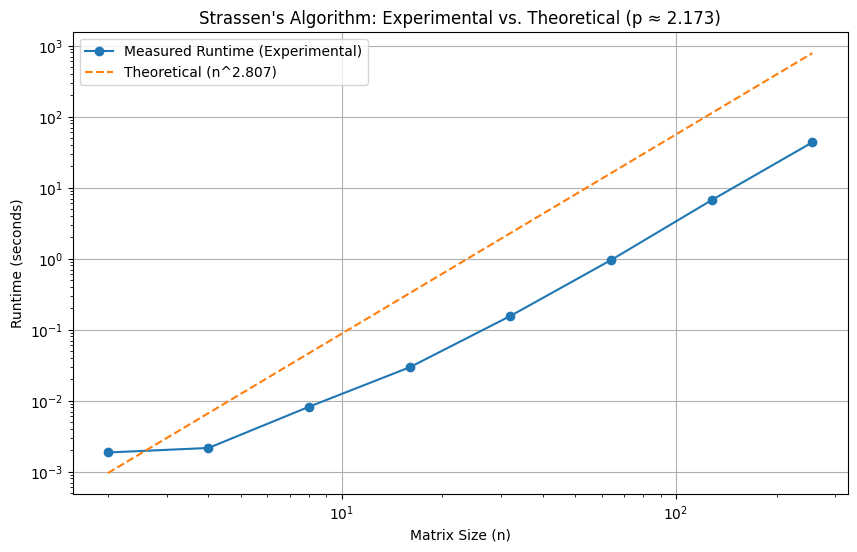

In [27]:
# Measure execution time for increasing matrix sizes
matrix_sizes = [2**i for i in range(1, 9)]  # Sizes: 2, 4, 8, ..., 256
runtimes = []

for size in matrix_sizes:
    A = np.random.rand(size, size)
    B = np.random.rand(size, size)
    start_time = time.time()
    strassen_matrix_mult(A, B)
    end_time = time.time()
    runtimes.append(end_time - start_time)

# Fit runtime to T(n) = c * n^p
log_sizes = np.log(matrix_sizes)
log_runtimes = np.log(runtimes)
p, log_c = np.polyfit(log_sizes, log_runtimes, 1)
c = np.exp(log_c)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(matrix_sizes, runtimes, 'o-', label="Measured Runtime (Experimental)")
plt.plot(matrix_sizes, c * np.array(matrix_sizes)**2.807, '--', label="Theoretical (n^2.807)")
plt.xlabel("Matrix Size (n)")
plt.ylabel("Runtime (seconds)")
plt.xscale("log")
plt.yscale("log")
plt.title(f"Strassen's Algorithm: Experimental vs. Theoretical (p ≈ {p:.3f})")
plt.legend()
plt.grid(True)
plt.show()

Yes, the asymptotic behavior of the measured and theoretical time complexity via the master's theorem agree. 

**Task 2: Heisenberg XXX Hamiltonian on a Ring**

Question 1

In [31]:
# Define the Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
identity = np.eye(2, dtype=complex)

# Function to create the Heisenberg XXX Hamiltonian matrix
def heisenberg_xxx_hamiltonian(N, J=1.0):
    """
    Constructs the Heisenberg XXX Hamiltonian for a chain of N spins.

    Parameters:
    N (int): Number of spins in the chain.
    J (float): Coupling constant.

    Returns:
    scipy.sparse.dok_matrix: The Hamiltonian matrix in sparse format.
    """
    # Dimension of the Hilbert space
    dim = 2**N

    # Initialize the Hamiltonian as a sparse matrix
    H = dok_matrix((dim, dim), dtype=complex)

    # Iterate over all pairs of neighboring spins (including periodic boundary conditions)
    for i in range(N):
        # Define the indices of the interacting spins (i and i+1, with PBC)
        j = (i + 1) % N

        # Create SxSx, SySy, SzSz terms
        for op in [(sigma_x, sigma_x), (sigma_y, sigma_y), (sigma_z, sigma_z)]:
            H += J * local_two_spin_operator(N, i, j, op[0], op[1])

    return H.tocsr()  # Convert to CSR format for efficiency

# Function to construct two-spin interaction terms in the Hamiltonian
def local_two_spin_operator(N, i, j, op1, op2):
    """
    Constructs a two-spin interaction term in the Hamiltonian.

    Parameters:
    N (int): Number of spins in the chain.
    i (int): Index of the first spin.
    j (int): Index of the second spin.
    op1 (np.ndarray): Operator acting on the first spin.
    op2 (np.ndarray): Operator acting on the second spin.

    Returns:
    scipy.sparse.dok_matrix: The interaction term matrix.
    """
    dim = 2**N
    term = dok_matrix((dim, dim), dtype=complex)

    for state in range(dim):
        # Convert state index to binary representation
        binary_state = format(state, f'0{N}b')

        # Apply the operators to the two spins
        new_state, coeff = apply_operators(binary_state, i, j, op1, op2)

        # Map the new state back to an integer index
        new_state_index = int(new_state, 2)

        # Update the Hamiltonian term
        term[state, new_state_index] = coeff

    return term

# Function to apply spin operators to a binary state
def apply_operators(state, i, j, op1, op2):
    """
    Applies spin operators to a binary state.

    Parameters:
    state (str): Binary representation of the state.
    i (int): Index of the first spin.
    j (int): Index of the second spin.
    op1 (np.ndarray): Operator acting on the first spin.
    op2 (np.ndarray): Operator acting on the second spin.

    Returns:
    str: New binary state after applying the operators.
    complex: Coefficient of the new state.
    """
    N = len(state)

    # Extract the two spins to be operated on
    spin_i = int(state[i])
    spin_j = int(state[j])

    # Create the local 4x4 matrix for the two spins
    local_matrix = np.kron(op1, op2)

    # Determine the new state and coefficient
    local_state = np.array([spin_i, spin_j])
    new_local_state = local_matrix @ np.eye(4)[:, spin_i * 2 + spin_j]

    # Check if the new state is valid
    nonzero_indices = np.where(np.abs(new_local_state) > 1e-12)[0]
    if len(nonzero_indices) != 1:
        return state, 0

    new_spin_i, new_spin_j = divmod(nonzero_indices[0], 2)

    # Replace spins in the original state
    new_state = list(state)
    new_state[i] = str(new_spin_i)
    new_state[j] = str(new_spin_j)

    return ''.join(new_state), new_local_state[nonzero_indices[0]]

In [30]:
# Example usage
if __name__ == "__main__":
    N = 4  # Number of spins
    J = 1.0  # Coupling constant

    H = heisenberg_xxx_hamiltonian(N, J)

    # Compute the lowest eigenvalues for the Hamiltonian
    eigenvalues, eigenvectors = eigsh(H, k=2, which='SA')

    print("Lowest eigenvalues:", eigenvalues)

Lowest eigenvalues: [-8. -4.]


Eigenvalue of the Hamiltonian represents the energy of the state. Lowest eigenvalue corresponds with the ground state, second lowest is for the first excited state. 

In [37]:
def construct_hamiltonian(N, J=1):
    """Construct the Heisenberg XXX Hamiltonian for N spins."""
    dim = 2 ** N
    data, rows, cols = [], [], []

    for state in range(dim):
        for i in range(N):
            # Periodic boundary conditions
            j = (i + 1) % N

            # Compute interaction between spins i and j
            si = (state >> i) & 1
            sj = (state >> j) & 1

            if si == sj:
                # Same spin: contribution +1/4
                data.append(J / 4)
                rows.append(state)
                cols.append(state)
            else:
                # Opposite spin: contribution -1/4 and flip spins
                data.append(-J / 4)
                rows.append(state)
                cols.append(state)

                # Flip spins i and j
                flipped_state = state ^ (1 << i) ^ (1 << j)
                data.append(-J / 2)
                rows.append(flipped_state)
                cols.append(state)

    return csr_matrix((data, (rows, cols)), shape=(dim, dim))

def time_complexity_test(max_N, J=1):
    """Measure Hamiltonian construction and eigenvalue computation times."""
    results = []

    for N in range(2, max_N + 1):
        dim = 2 ** N

        # Time Hamiltonian construction
        start_time = time.time()
        H = construct_hamiltonian(N, J)
        construction_time = time.time() - start_time

        # Time eigenvalue computation
        start_time = time.time()
        eigsh(H, k=2, which='SA')  # Compute the 2 lowest eigenvalues
        eigensolver_time = time.time() - start_time

        results.append((N, dim, construction_time, eigensolver_time))

    return results

# Run the time complexity test for N = 2 to 16
results = time_complexity_test(max_N=16)

# Print the results
print(f"{'N':>2} {'Hilbert Space Dim':>18} {'Construction Time (s)':>25} {'Eigenvalue Time (s)':>20}")
for N, dim, construction_time, eigensolver_time in results:
    print(f"{N:>2} {dim:>18} {construction_time:>25.5f} {eigensolver_time:>20.5f}")

 N  Hilbert Space Dim     Construction Time (s)  Eigenvalue Time (s)
 2                  4                   0.00094              0.00221
 3                  8                   0.00087              0.00302
 4                 16                   0.00190              0.00478
 5                 32                   0.00105              0.00171
 6                 64                   0.00134              0.00426
 7                128                   0.00367              0.01092
 8                256                   0.00665              0.00725
 9                512                   0.01124              0.02319
10               1024                   0.02001              0.01338
11               2048                   0.05730              0.02236
12               4096                   0.09641              0.10292
13               8192                   0.17191              0.08218
14              16384                   0.34912              0.12442
15              32768             

Question 2

In [52]:
def qr_algorithm(H, tol=1e-10, max_iterations=500000):
    """
    Perform the QR algorithm to diagonalize a matrix.

    Parameters:
        H (ndarray): The input matrix (must be square).
        tol (float): Convergence tolerance for off-diagonal elements.
        max_iterations (int): Maximum number of iterations.

    Returns:
        H_diag (ndarray): The diagonalized matrix.
        iterations (int): The number of iterations performed.
    """
    H_current = H.copy()
    iterations = 0

    for _ in range(max_iterations):
        iterations += 1

        # Perform QR decomposition
        Q, R = np.linalg.qr(H_current)

        # Construct the next matrix H
        H_next = R @ Q

        # Check convergence (off-diagonal elements close to zero)
        if np.allclose(H_next - np.diag(np.diag(H_next)), 0, atol=tol):
            break

        H_current = H_next

    return H_next, iterations

# Example usage
if __name__ == "__main__":
    # Define a sample Hamiltonian matrix
    H = np.random.randint(-10, 10, size=(3, 3))
    print(H)

    # Apply the QR algorithm
    H_diag, num_iterations = qr_algorithm(H)

    # Print results
    print("Diagonalized matrix:")
    print(H_diag)
    print(f"Number of iterations: {num_iterations}")

[[ 5  1  0]
 [-2 -8 -9]
 [ 7  2 -5]]
Diagonalized matrix:
[[ -2.06905435   4.72997216   7.88923736]
 [ -5.93188795 -10.32231609   1.75632367]
 [  0.           0.           4.39137044]]
Number of iterations: 500000


Question 3: Green's Function

In [ ]:
def greens_function(omega, H):
    """
    Compute the Green's function G for the equation (omega*I - H)G = I.

    Parameters:
        omega (float): Frequency.
        H (ndarray): Hermitian Hamiltonian matrix.

    Returns:
        G (ndarray): Green's function matrix.
    """
    # Ensure H is a numpy array
    H = np.array(H)

    # Dimension of the Hamiltonian matrix
    n = H.shape[0]

    # Construct (omega*I - H)
    omega_I_minus_H = omega * np.eye(n) - H

    # Perform LU decomposition
    lu, piv = lu_factor(omega_I_minus_H)

    # Solve for G using the LU decomposition
    G = lu_solve((lu, piv), np.eye(n))

    return G

# Example usage
if __name__ == "__main__":
    # Define a sample Hamiltonian matrix
    H = np.array([[0, -1, 0, 0],
                  [-1, 0, -1, 0],
                  [0, -1, 0, -1],
                  [0, 0, -1, 0]])

    # Define a frequency omega
    omega = 2.0

    # Compute the Green's function
    G = greens_function(omega, H)

    # Print results
    print("Green's function G:")
    print(G)